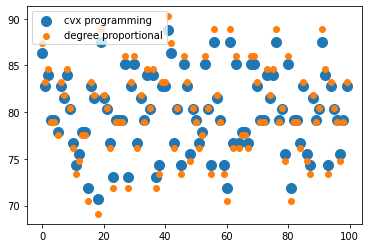

In [4]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import random
import math

def erdos_renyi_graph(N, M):
  graph = []
  node_list = [i for i in range(N)]
  numEdges = 0
  while numEdges < M:
    edge = random.sample(node_list, 2)
    if edge not in graph:
      numEdges += 1
      graph.append(edge)
  return graph



def cvx_find_rho(A, beta, budget, N, eps=0):
    w = cp.Variable(N)
    z = cp.Variable(N)
    log_of_budget = np.log(1/budget)
    y = np.log(beta*np.ones(N))
    objective = cp.Minimize(cp.atoms.log_sum_exp(w)) #cp.log(1 + cp.sum(cp.exp(w))) ~ sum(v)
    # constraints = [beta*((v.T)@A) + rho <= cp.multiply(v,rho), cp.sum(rho) == budget, v>= 0]
    # constraints = [cp.log(cp.sum(cp.exp(A@(w + y))) + cp.sum(cp.exp(A@y))) - (w + z) + 0.00001 <= 0, 
                  #  cp.log(1/budget * cp.sum(cp.exp(z))) <= 0, cp.exp(z) >= 0] 
    # , cp.atoms.log_sum_exp(cp.hstack([A@(w + y), A@y])) - (w + z) + 0.00001 <= 0
    constraints = [cp.atoms.log_sum_exp(z + np.ones(N)*log_of_budget) <= 0]
    for i in range(N):
      inds = []
      for j in range(N):
        if (A[i][j] == 1):
          inds.append(j)
      new_vec = (w + y)[inds]
      new_vec_y = y[inds]
      if len(inds) > 0:
        constraints.append(cp.atoms.log_sum_exp(cp.hstack([new_vec, new_vec_y]))- (w[i] + z[i]) + eps <= 0)
        
      # constraints.append(cp.atoms.log_sum_exp(cp.hstack([cp.multiply(A[i], w + y), cp.multiply(A[i], y)])) - (w[i] + y[i]) + 0.00001 <= 0)
    prob = cp.Problem(objective, constraints)
    # print("Optimal value", prob.solve())
    prob.solve()
    # print("Values of delta_i", np.exp(z.value))
    # print("Values of v", np.exp(w.value) + 1)
    # print("Value of budget used", np.exp(cp.atoms.log_sum_exp(z).value))
    # print("Optimal var", z.value)
    return np.exp(z.value) # A numpy ndarray.


def tuples_to_adj(graph, N):
    #print (N)
    adj_matrix = np.zeros((N, N))
    for edge in graph:
        adj_matrix[edge[0]][edge[1]] = 1
        adj_matrix[edge[1]][edge[0]] = 1
    #print (adj_matrix)
    return adj_matrix

def barbell(n1, n2):
  graph = []
  for node in range(0, n1):
    for neighbor in range(0, n1):
      if (node != neighbor):
        graph.append([node, neighbor])
  for node in range(n1, n1+n2):
    for neighbor in range(n1, n1+n2):
      if (node != neighbor):
        graph.append([node, neighbor])
  node1 = np.random.randint(0, n1)
  node2 = np.random.randint(n1, n1+n2)
  graph.append([node1, node2])
  graph.append([node2, node1])
  return graph

def regular_lattice(N):
  size = int(math.sqrt(N))
  if (size**2 != N):
    size = size
  lattice = []
  i = 0
  while (i < N):
    row = []
    for _ in range(size):
      if (i > N):
        row.append(0)
      else:
        row.append(i)
        i += 1
    lattice.append(row)
  print(lattice)
  graph = []
  for i in range(size):
    for j in range(size):
      graph.append([lattice[i][j], lattice[i][(j+1)% size]])
      graph.append([lattice[i][(j+1)% size], lattice[i][j]])
      
  for i in range(size):
    for j in range(size):
      graph.append([lattice[i][j], lattice[(i+1)%size][j]])
      graph.append([lattice[(i+1)%size][j], lattice[i][j]])
  return graph

def stochastic_block(n, r, P):
  graph = []
  node_list = np.arange(n)
  communities = np.array_split(node_list, r)
  for i in range(r):
    for j in range(r):
      C_i = communities[i]
      C_j = communities[j]
      p_ij = P[i][j]
      for node1 in C_i:
        for node2 in C_j:
          if node1 != node2:
            if np.random.rand() < p_ij:
                graph.append([node1, node2])
  return graph


def find_degree(node, graph):
  degree = 0
  for edge in graph:
    if edge[0] == node:
      degree += 1
  return degree

def make_deg_dict(graph, curr_nodes):
  degDict = {}
  for i in curr_nodes:
    degDict[i] = find_degree(i, graph)
  return degDict

def sum_degs(graph, curr_nodes):
  sum = 0
  for node in curr_nodes:
    deg = find_degree(node, graph)
    sum += deg
  return sum

def pref_attachment(graph, curr_nodes,n, N):
  degDict = make_deg_dict(graph, curr_nodes)
  for i in range(N):
    new_node = n + i
    degDict[new_node] = 0
    for node in curr_nodes:
      deg = degDict[node]
      sum = sum_degs(graph, curr_nodes)
      p_node = deg/sum
      if np.random.rand() < p_node:
        graph.append([node, new_node])
        degDict[node] += 1
        graph.append([new_node, node])
        degDict[new_node] += 1
    curr_nodes.append(new_node)
  return graph

def recovery_rates(graph, initial_recovery_rate, budget, numOfNodes):
    degDict = {}
    sum = len(graph)
    for edge in graph:
        if edge[0] not in degDict:
            degDict[edge[0]] = 0
        degDict[edge[0]] += 1
    print (degDict)
    recoveryRates = {}
    for node in range(numOfNodes):
        if node in degDict:
          recoveryRates[node] = initial_recovery_rate + (degDict[node]/sum)*budget
        else: 
          recoveryRates[node] = initial_recovery_rate
    return recoveryRates 

def cvx_halfEdge(graph, beta, budget, N, M, x, j, init_inf_edges, eps=0):
  w = cp.Variable(M)   # arbitrary vector, log(v - x)
  y = np.ones(M)*beta  # trasmission rate (constant)
  z = cp.Variable(N)   # optimal recovery rates of each node
  log_of_budget = np.log(1/budget)  # budget
  X = np.diag(x)    # inverse of edge degrees
  # init inf edges = I(0)
  # j is a vector where j(k, l) is 1 when the edge (k, l) is susceptible at time 0

  log_x = np.log(x)
  # inds = []
  # # Choosing the indices such that the edge is initially infected
  # for i in range(M):
  #   if graph[i] in init_inf_edges: 
  #     inds.append(i)
  # init_w = w[inds]
  # init_x = x[inds]
  # init_log_x = np.log(init_x)
  # objective = cp.Minimize(cp.atoms.log_sum_exp(cp.hstack([init_w, init_log_x]))) #log(sum(exp(w in I(0))) + sum(x in I(0)))
  objective = cp.Minimize(cp.atoms.log_sum_exp(cp.hstack([w, log_x])))
  constraints = []
  for index in range(M):
    edge = graph[index] #(i, j)
    nbr_inds = []
    # Choosing the indices such that the edge ends at node 0 but is not back-tracking
    for i in range(M): #not (j, i) but an edge of the form (u, i)
      if graph[i][1] == edge[0] and graph[i][0] != edge[1]:
        nbr_inds.append(i)
    new_w = w[nbr_inds]
    log_new_x = np.log(x[nbr_inds])
    # print (log_new_x)
    new_j = np.log(j[nbr_inds])
    new_y = np.log(y[nbr_inds])
    # print (graph[index][0])
    if len(nbr_inds) > 0:
      constraints.append(cp.atoms.log_sum_exp(cp.hstack([new_w + new_j + new_y, log_new_x + new_j + new_y])) - (w[index] + z[graph[index][0]]) + eps <=0)
  constraints.append(cp.atoms.log_sum_exp(z + np.ones(N)*log_of_budget) <= 0) #log_of_budget = log(1/budget)
  prob = cp.Problem(objective, constraints)
  prob.solve()
  return np.exp(z.value)

# 
N = 100
r = 2
P = np.zeros((r,r))
P[0][0] = 0.8
P[1][1] = 0.8
P[0][1] = 0.1
P[1][0] = 0.1
graph = stochastic_block(N, r, P)
# graph = barbell(30, 70)
# graph = erdos_renyi_graph(N, 500)
# print (graph)
budget = 8000
# # simple_graph = np.array([[0, 1], [1, 0]])
rhos = cvx_find_rho(tuples_to_adj(graph, N), 1, budget, N)
plt.scatter(range(len(rhos)), rhos, s=100, label="cvx programming")
A = tuples_to_adj(graph, N)
rhos2 = budget*np.sum(A, axis=0)/np.sum(A)
plt.scatter(range(len(rhos)), rhos2, label="degree proportional")
plt.legend()
# print (cvx_find_rho(simple_graph, 1, 10, 2))
# print (cvx_find_rho(tuples_to_adj(erdos_renyi_graph(100, 300), 100), 0.7, 700, N))







In [9]:
def find_connected_nodes(node, graph_dict, connected_component):
  if node not in connected_component:
    connected_component.append(node)
  for neighbor in graph_dict[node]:
    if neighbor not in connected_component:
      find_connected_nodes(neighbor, graph_dict, connected_component)

def find_entire_connection(infected_nodes, graph_dict):
  #print (len(graph)/N)
  # graph_dict = tuples_to_dict(graph, N)
  #print (graph_dict)
  connected_nodes = []
  for node in infected_nodes:
    find_connected_nodes(node, graph_dict, connected_nodes)
  #print(connected_nodes)   
  return connected_nodes

def percolation(neighbors_per_node, transmissionRate, recoveryRates):
    graph = []
    for node in neighbors_per_node:
        if recoveryRates[node] < 0:
          recoveryRates[node] = 0
        recoveryTime = np.random.exponential(1/(recoveryRates[node]))
        for neighbor in neighbors_per_node[node]:
            transmissionTime = np.random.exponential(1/transmissionRate)
            if (transmissionTime <= recoveryTime):
                graph.append([node, neighbor])
    return graph

def tuples_to_dict(graph, N):
  graph_dict = {}
  for i in range(N):
    graph_dict[i] = []
  for edge in graph:
    graph_dict[edge[0]].append(edge[1])
  return graph_dict

def calculateFinalInfection(graph, numOfNodes, numOfTrials, transmissionRate, budget, neighbors_per_node, recoveryRates):
  num_infected = []
  for _ in range(numOfTrials):
    graph1 = percolation(neighbors_per_node, transmissionRate, recoveryRates)
    neighbors_per_node2 = tuples_to_dict(graph1, numOfNodes)
    inf_size = []
    for i in range(20):
      source = random.sample([i for i in range(0, N)], 1)
      infected_nodes = find_entire_connection(source, neighbors_per_node2)
      inf_size.append(len(infected_nodes))
    num_infected.append(np.mean(inf_size))
  return np.mean(num_infected)

50
60
70
80
90


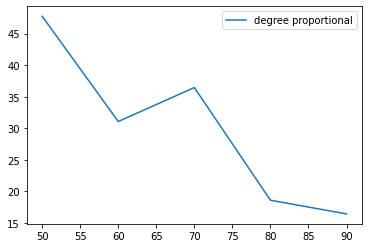

In [15]:

def find_x(graph):
  x = []
  degDict = {}
  for edge in graph:
    if edge[0] not in degDict:
        degDict[edge[0]] = 0
    degDict[edge[0]] += 1
  for edge in graph:
    x.append(1/degDict[edge[0]])
  return np.array(x)

budgets = np.arange(50, 100, 10)
numTrials = 5
beta = 0.5
N = 100
r = 2
P = np.zeros((r,r))
P[0][0] = 0.8
P[1][1] = 0.8
P[0][1] = 0.1
P[1][0] = 0.1
# graph = stochastic_block(N, r, P)

# graph = barbell(30, 70)
graph = erdos_renyi_graph(N, 400)
# graph = pref_attachment([[0, 1], [1, 0]], [0, 1], 2, N - 2)
# graph = regular_lattice(N)
M =len(graph)
graph_dict = tuples_to_dict(graph, N)
A = tuples_to_adj(graph, N)


Y1 = []
Y2 = []

j = np.ones(M)
x = find_x(graph)
init_inf_edges = []
Y3 = []
for budget in budgets:
  print (budget)
  # rhos = cvx_find_rho(A, beta, budget, N)
  rhos2 = budget*np.sum(A, axis=0)/np.sum(A)
  # rhos3 = cvx_halfEdge(graph,beta, budget, N, M, x, j, init_inf_edges)
  # Y1.append(calculateFinalInfection(graph, N, numTrials, beta, budget, graph_dict, rhos))
  Y2.append(calculateFinalInfection(graph, N, numTrials, beta, budget, graph_dict, rhos2))
  # Y3.append(calculateFinalInfection(graph, N, numTrials, beta, budget, graph_dict, rhos3))

# plt.plot(budgets, Y1, label="convex programming")
plt.plot(budgets, Y2, label="degree proportional")
# plt.plot(budgets, Y3, label="half edge convex")
plt.legend()


